In [28]:
!pip install monai==1.0

In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import re
import cc3d

from monai.transforms import (MapTransform, Compose, Transposed, ToTensord, Resized)
from monai.data import Dataset, DataLoader
from datasets import load_dataset

In [7]:
config_kwargs = {
    "lesion_density": ["1.0"],
    "dose": ["100%"],
    "density": ["fatty"],
    "size": ["5.0"]
}

In [8]:
ds_data = load_dataset("didsr/msynth", 'device_data', **config_kwargs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for didsr/msynth contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/didsr/msynth
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

Generating device_data split: 0 examples [00:00, ? examples/s]

In [9]:
ds_seg = load_dataset("didsr/msynth", 'segmentation_mask', **config_kwargs)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for didsr/msynth contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/didsr/msynth
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating segmentation_mask split: 0 examples [00:00, ? examples/s]

In [10]:
from pathlib import Path
mask_files = [f for f in ds_seg['segmentation_mask']['mhd'] if Path(f).stem != 'None']
mask_ids = [int(Path(f).parents[0].stem) for f in mask_files]
image_files = [f for f in ds_data['device_data']['mhd'] if int(Path(f).parents[0].stem) in mask_ids]

datadict = [{'image': im, 'mask': m} for im, m in zip(image_files, mask_files)]

In [64]:
datadict = datadict[:10]
datadict[0]

{'image': '/root/.cache/huggingface/datasets/downloads/extracted/6d0e538ef90c267e5d280128ce025f72b90068443475b6503350ed4b6a76b5df/SIM/P2_5.0_fatty.8335962.1/1/projection_DM1.mhd',
 'mask': '/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.1/seg/1/projection_DM1.mhd'}

In [12]:
!pip install connected-components-3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 7.2 MB/s eta 0:00:00


In [14]:
def read_mhd(filename):
    if 'None' in filename:
        return None
    data = {}
    with open(filename, "r") as f:
        for line in f:
            s = re.search("([a-zA-Z]*) = (.*)", line)
            data[s[1]] = s[2]

            if " " in data[s[1]]:
                data[s[1]] = data[s[1]].split(" ")
                for i in range(len(data[s[1]])):
                    if data[s[1]][i].replace(".", "").replace("-", "").isnumeric():
                        if "." in data[s[1]][i]:
                            data[s[1]][i] = float(data[s[1]][i])
                        else:
                            data[s[1]][i] = int(data[s[1]][i])
            else:
                if data[s[1]].replace(".", "").replace("-", "").isnumeric():
                    if "." in data[s[1]]:
                        data[s[1]] = float(data[s[1]])
                    else:
                        data[s[1]] = int(data[s[1]])
    return data

In [15]:
class LoadMSynthMaskd(MapTransform):
    """
        Load the mask from the MSynth dataset.
    """
    def __call__(self, data):
        d = dict(data)
        d['mask'] = str(d['mask'])
        data = read_mhd(d['mask'])
        pixel_array = np.fromfile(d["mask"].replace('mhd', 'raw'), dtype="float32").reshape(
            data["NDims"], data["DimSize"][1], data["DimSize"][0]
        )
        tmp = pixel_array[0]
        X = np.std(tmp) * 2
        TH = np.mean(tmp)
        tmp[tmp < TH - X] = 0
        tmp[tmp > TH + X] = X + TH
        tmp = tmp > 4

        # remove noisy small objects
        tmp = cc3d.largest_k(tmp.astype(np.float32), k=1, connectivity=8)

        # monai requires channel to be in the 1st dimension
        d['mask'] = np.expand_dims(tmp, axis=0).astype(np.float32)
        return d

In [16]:
class LoadMSynthImaged(MapTransform):
    """
        Load the image from the MSynth dataset.
    """
    def __call__(self, data):
        d = dict(data)
        d['image'] = str(d['image'])
        data = read_mhd(d['image'])
        pixel_array = np.fromfile(d["image"].replace('mhd', 'raw'), dtype="float32").reshape(
            data["NDims"], data["DimSize"][1], data["DimSize"][0]
        )
        tmp = pixel_array[0]
        X = np.std(tmp) * 2 # 4 # 3 # 2
        TH = np.mean(tmp)
        tmp[tmp < TH - X] = 0
        tmp[tmp > TH + X] = X + TH

        # monai requires channel to be in the 1st dimension
        d['image'] = np.expand_dims(tmp, axis=0).astype(np.float32)
        return d

In [17]:
class WindowMSynthImaged(MapTransform):
    """
        Window the image from the MSynth dataset.
    """

    def __call__(self, data):
        d = dict(data)
        d['image'] = (d['image'] - np.amin(d['image']))/np.ptp(d['image'])
        return d

In [18]:
class ConvertMSynthLesionToMultiChannelMaskd(MapTransform):
    """
        Convert multi-label singe-channel mask to multiple-channel one-hot encoded
    """
    def __call__(self, data):
        d = dict(data)
        background = d['mask'][0] == 0
        lesion = d['mask'][0] == 1
        d['segmentation'] = np.stack((background, lesion), axis=0)
        return d

In [65]:
transforms = Compose([
    # Load image and mask
    LoadMSynthImaged(keys=['image']),
    LoadMSynthMaskd(keys=['mask']),

    # Transpose and windowing
    Transposed(keys=['image', 'mask'], indices=[0, 2, 1]),
    WindowMSynthImaged(keys=['image']),

    # Resize to fit UNet requirements
    Resized(keys=['image'], spatial_size=[2048, 1024]),
    Resized(keys=['mask'], spatial_size=[2048, 1024], mode='nearest'),

    # Convert mask to one-hot encoded representation
    ConvertMSynthLesionToMultiChannelMaskd(keys=['mask']),
    ToTensord(keys=['image', 'mask', 'segmentation'])
])
dataset = Dataset(data=datadict, transform=transforms)

In [66]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [67]:
sample = next(iter(train_loader))

/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.9/seg/9/projection_DM9.mhd


In [68]:
sample.keys()

dict_keys(['image', 'mask', 'segmentation', 'segmentation_transforms'])

In [69]:
sample['image'].shape, sample['mask'].shape, sample['segmentation'].shape

((1, 1, 2048, 1024), (1, 1, 2048, 1024), (1, 2, 2048, 1024))

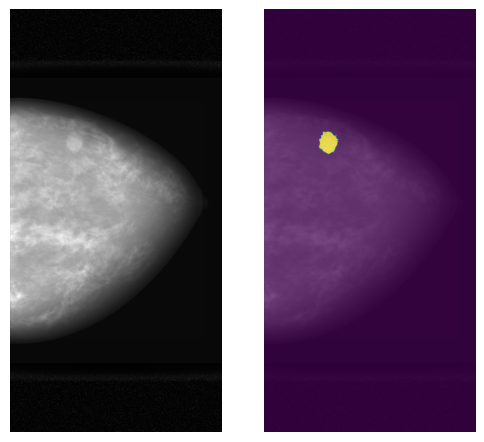

In [70]:
fig, ax = plt.subplots(1,2,figsize=(6,12))
ax[0].imshow(sample['image'][0,0].numpy(), cmap="gray")
ax[0].axis('off')

ax[1].imshow(sample['image'][0,0].numpy(),cmap='gray')
ax[1].imshow(sample['segmentation'][0,1].numpy(), alpha=0.7)
ax[1].axis('off')
plt.show()

In [71]:
from monai.networks.nets import UNet
model = UNet(spatial_dims=2, in_channels=1, out_channels=2,
             kernel_size=3, up_kernel_size=3,
             channels=(64, 128, 256),
             strides=(2, 2), num_res_units=0,
             norm='instance', dropout=.5)

In [72]:
import torch

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import EnsureType, AsDiscrete
from monai.data.utils import decollate_batch

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
criterion = DiceLoss(softmax=True, include_background=True)
metric = DiceMetric(include_background=False, reduction="mean")

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType()])

In [ ]:
for epoch in range(2):
    for batch_data in train_loader:
        inputs, labels = batch_data['image'], batch_data['segmentation']

        optimizer.zero_grad()
        outputs = model(inputs)

        loss_ep = criterion(outputs, labels)
        loss_ep.backward()

        _outputs = [post_pred(i) for i in decollate_batch(outputs)]
        _labels = [post_label(i) for i in decollate_batch(labels)]

        optimizer.step()
        metric(y_pred=_outputs, y=_labels)
    metric_ep = metric.aggregate().item()
    print(f'Epoch {epoch} of 10 with Train loss {loss_ep.item()}')
    print(f'Epoch {epoch} of 10 with Train metric {metric_ep}')
    print(f'-------------- Finished epoch {epoch} -------------')

/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.5/seg/5/projection_DM5.mhd
/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.1/seg/1/projection_DM1.mhd
/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.19/seg/19/projection_DM19.mhd
/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.11/seg/11/projection_DM11.mhd
/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.3/seg/3/projection_DM3.mhd
/root/.cache/huggingface/datasets/downloads/extracted/0d3b23026d8736144a10b240b188300de86c98adff8842248617adbfb7907e0b/SIM/P2_5.0_fatty.17/seg/17/projection_DM17.mhd
/root/.cache/